In [1]:
import json
import pandas as pd
import gzip
from music21 import *
humdrum.spineParser.flavors['JRP'] = True
from copy import deepcopy
import string

 
Music21 v.4 is the last version that will support Python 2.
Please start using Python 3 instead.

Set music21.environment.UserSettings()['warnings'] = 0
to disable this message.



In [2]:
%run -i '/Users/pvk/git/rhyme/python/classifiers.py'
mbpt = MBPT()

/Users/pvk/git/rhyme/python/config.pyc


Starting server at localhost:50202.........
Server up and running at localhost:50202


In [3]:
%run -i '/Users/pvk/Documents/Eigenwerk/Projects/Rhyme/rhyme.py'
%run -i '/Volumes/ethanpvk/Documents/Eigenwerk/Projects/Cadences/cadence_20150202.py'

Setting humdrum.spineParser.flavors['JRP'] = True


In [4]:
from pathlib2 import Path

In [5]:
mtcfsinstkrnpath = Path('/Users/pvk/data/MTC/MTC-FS-INST-2.0/krn/')
mtcannkrnpath = Path('/Users/pvk/data/MTC/MTC-ANN-2.0.1/krn/')

In [6]:
mtcfsinst_ids = [fp.stem for fp in mtcfsinstkrnpath.glob('*.krn')]
mtcann_ids = [fp.stem for fp in mtcannkrnpath.glob('*.krn')]

In [7]:
fsinst_song_metadata = pd.read_csv(
    '/Users/pvk/data/MTC/MTC-FS-INST-2.0/metadata/MTC-FS-INST-2.0.csv',
    na_filter=False,
    index_col=0,
    header=None,
    encoding='utf8',
    names=[
        "filename",
        "songid",
        "source_id",
        "serial_number",
        "page",
        "singer_id_s",
        "date_of_recording",
        "place_of_recording",
        "latitude",
        "longitude",
        "textfamily_id",
        "title",
        "firstline",
        "tunefamily_id",
        "tunefamily",
        "type",
        "voice_stanza_number",
        "voice_stanza",
        "image_filename_s",
        "audio_filename",
        "variation",
        "confidence",
        "comment",
        "MTC_title",
        "author"
    ]
)

In [8]:
def getSeqs(ids, path, song_metadata=None):
    seqs = []
    for nlbid in ids:
        try:
            if not len(seqs)%100:
                print len(seqs),
            if isinstance(song_metadata, pd.DataFrame):
                if song_metadata.loc[nlbid,'type'] != 'vocal':
                    continue
            #print nlbid
            s = converter.parse(str(path)+'/'+nlbid+'.krn')
            s.metadata.title = nlbid
            
            # Extract lyrics
            lyr = []
            for n in s.flat.notes:
                #tie?
                if n.tie:
                    if n.tie.type == 'stop' or n.tie.type == 'continue':
                        continue
                #gracenote?
                if n.quarterLength == 0.0:
                    continue
                if len(n.lyrics) > 0:
                    lyr.append(n.lyrics[0].rawText)
                else:
                    lyr.append('')

            addPhonemes(s)

            #do wordstress and noncontentwords before moving syllables to end of melismas

            removeNonContentsWords(s, annotateOnly=True)

            ncword, ws = [], []
            for n in s.flat.notes:
                #tie?
                if n.tie:
                    if n.tie.type == 'stop' or n.tie.type == 'continue':
                        continue
                #gracenote?
                if n.quarterLength == 0.0:
                    continue
                ncword.append(n.noncontentword)
                if len(n.lyrics) >= 3:
                    ws.append(True if n.lyrics[2].text == '1' else False)
                else:
                    ws.append(False)

            try:
                lyricsToAllOfMelisma(s, annotateOnly=True)
            except NoLyricsError as e:
                print e
                continue #skip this melody

            # for rhyme without content words (below)
            s2 = copy.deepcopy(s)

            words = collectPhonemeWords(s)
            rh,rh_dist = detectRhymeWords(words)
            addRhymeToSong(s,rh,words)

            # Extract stress, phonemes, rhyme, wordend (here because of lyricsToEndOfMelisma)
            wordend, phons, rhymes, melis = [], [], [], []
            for n in s.flat.notes:
                #tie?
                if n.tie:
                    if n.tie.type == 'stop' or n.tie.type == 'continue':
                        continue
                #gracenote?
                if n.quarterLength == 0.0:
                    continue
                melis.append(n.melismastatus)
                if n.melismastatus == 'end':
                    if n.lyrics:
                        if n.lyrics[0].syllabic == 'single' or n.lyrics[0].syllabic == 'end':
                            wordend.append(True)
                        else:
                            wordend.append(False)
                    else:
                        wordend.append(True) #actually not applicable...
                else:
                    wordend.append(False) #in melisma
                if len(n.lyrics) >= 4:
                    phons.append(n.lyrics[1].text)
                    rhymes.append(True if n.lyrics[3].text == 'True' else False)
                else:
                    phons.append('')
                    rhymes.append(False)

            # with contentwords only:
            removeNonContentsWords(s2)
            words = collectPhonemeWords(s2)
            rh,rh_dist = detectRhymeWords(words)
            addRhymeToSong(s2,rh,words)

            # Extract stress, phonemes, rhyme
            rhymescontentwords = []
            for n in s2.flat.notes:
                #tie?
                if n.tie:
                    if n.tie.type == 'stop' or n.tie.type == 'continue':
                        continue
                #gracenote?
                if n.quarterLength == 0.0:
                    continue
                if len(n.lyrics) >= 4:
                    rhymescontentwords.append(True if n.lyrics[3].text == 'True' else False)
                else:
                    rhymescontentwords.append(False)


            seq = {
                'id':nlbid,
                'features' : {
                    'lyrics' : lyr,
                    'noncontentword' : ncword,
                    'melismastate': melis,
                    'wordend' : wordend,
                    'wordstress' : ws,
                    'phoneme' : phons,
                    'rhymes' : rhymes,
                    'rhymescontentwords' : rhymescontentwords
                }
            }
            seqs.append(seq)
        except:
            print "Error", nlbid
            raise
    return seqs

#save as .jsonl
def saveSeqs(seqs, filename):
    with open(filename, 'w') as outfile:
        for seq in seqs:
            outfile.write(json.dumps(seq)+'\n')


In [9]:
#timblserver still functioning properly?
assert mbpt.phonologize('stad') == u"'stAt"

In [15]:
mbpt.phonologize("aan't")

u"''kAnt"

In [10]:
mtcann_seqs = getSeqs(mtcann_ids, mtcannkrnpath)
saveSeqs(mtcann_seqs,'mtcann_textfeatures_nopunctuation.jsonl')

0 100 200 300


In [11]:
mtcfsinst_seqs = getSeqs(mtcfsinst_ids, mtcfsinstkrnpath, song_metadata=fsinst_song_metadata)
saveSeqs(mtcfsinst_seqs,'mtcfsinst_textfeatures_nopunctuation.jsonl')

0 0 'NLB179932_01: no lyrics at first note.'
'NLB175861_01: no lyrics at first note.'
'NLB175902_01: no lyrics at first note.'
100 'NLB142256_01: no lyrics at first note.'
'NLB179920_01: no lyrics at first note.'
'NLB175873_01: no lyrics at first note.'
200 200 'NLB175938_01: no lyrics at first note.'
'NLB179916_01: no lyrics at first note.'
300 300 300 'NLB175945_01: no lyrics at first note.'
'NLB175826_01: no lyrics at first note.'
'NLB175926_01: no lyrics at first note.'
'NLB004881_01: no lyrics at first note.'
400 'NLB004794_01: no lyrics at first note.'
500 500 500 'NLB175934_01: no lyrics at first note.'
'NLB175834_01: no lyrics at first note.'
'NLB179867_01: no lyrics at first note.'
'NLB004786_01: no lyrics at first note.'
'NLB175849_01: no lyrics at first note.'
'NLB004844_01: no lyrics at first note.'
600 600 'NLB004839_01: no lyrics at first note.'
'NLB175795_01: no lyrics at first note.'
'NLB004827_01: no lyrics at first note.'
'NLB004856_01: no lyrics at first note.'
700 '

In [34]:
%run -i '/Users/pvk/Documents/Eigenwerk/Projects/Rhyme/rhyme.py'
tst_seq = getSeqs(['NLB075079_01'], mtcfsinstkrnpath, song_metadata=fsinst_song_metadata)

Setting humdrum.spineParser.flavors['JRP'] = True
NLB075079_01
0


In [35]:
list(zip(tst_seq[0]['features']['lyrics'],tst_seq[0]['features']['phoneme'],tst_seq[0]['features']['noncontentword']))

[(" 't Was", u'twAs', False),
 ('prach-', u'prAx', False),
 ('-tig', u't@x', False),
 ('zon-', u'zO', False),
 ('-nig', u'n@x', False),
 ('weer', u'wer', False),
 ('Uit', u'Y+t', True),
 ('rij-', u'rE+', False),
 ('-den', u'd@', False),
 ('zo', u'zo', True),
 ('gin-', '', False),
 ('-gen', '', False),
 ('zij', u'zE+', True),
 ('weer', u'wer', False),
 ('En', u'En', True),
 ('zij', u'zE+', True),
 ('ren-', u'rEn', False),
 ('-den', u'd@', False),
 ('wel-', u'wEl', False),
 ('-ge-', u'G@', False),
 ('-moed', u'mut', False),
 ('Tot', u'tOt', True),
 ('aan', u'an', True),
 ('den', u'dEn', False),
 ('a-', u'a', False),
 ('-vond', u'vOnt', False),
 ('toe', u'tu', False)]

In [12]:
def loadSeq(filename, nlbid):
    if Path(filename).suffix == ".gz":
        opener = gzip.open
    else:
        opener = open
    with opener(filename, "r") as f:
        for line in f:
            seq = json.loads(line)
            if seq['id'] == nlbid:
                return seq

In [13]:
seq = loadSeq('mtcfsinst_textfeatures.jsonl', 'NLB123273_01')

In [14]:
len(seq['features']['lyrics'])

40

In [64]:
s = converter.parse('/Users/pvk/data/MTC/MTC-FS-INST-2.0/krn/NLB188375_01.krn')

In [72]:
fl = s.flat.notes
ixs = []
for ix, n in enumerate(fl):
    if n.quarterLength == 0.0:
        ixs.append(ix)
print ixs

[10, 16, 86, 88, 103]


In [73]:
for ix, n in enumerate(fl):
    print ix, n, n.quarterLength

0 <music21.note.Note D> 1.0
1 <music21.note.Note F#> 1.0
2 <music21.note.Note A> 1.0
3 <music21.note.Note D> 2.0
4 <music21.note.Note A> 1.0
5 <music21.note.Note B> 1/3
6 <music21.note.Note A> 1/3
7 <music21.note.Note G> 1/3
8 <music21.note.Note F#> 1.0
9 <music21.note.Note E> 1.0
10 <music21.note.Note E> 0.0
11 <music21.note.Note F#> 2.0
12 <music21.note.Note A> 1.0
13 <music21.note.Note B> 0.5
14 <music21.note.Note C#> 0.5
15 <music21.note.Note D> 1.0
16 <music21.note.Note C#> 0.0
17 <music21.note.Note B> 1.0
18 <music21.note.Note A> 1.0
19 <music21.note.Note D> 1.0
20 <music21.note.Note F#> 1.0
21 <music21.note.Note G> 1/3
22 <music21.note.Note A> 1/3
23 <music21.note.Note B> 1/3
24 <music21.note.Note A> 1.0
25 <music21.note.Note G> 1.0
26 <music21.note.Note F#> 1/3
27 <music21.note.Note E> 1/3
28 <music21.note.Note D> 1/3
29 <music21.note.Note D> 1.0
30 <music21.note.Note A> 1.0
31 <music21.note.Note A> 1.0
32 <music21.note.Note G#> 1.0
33 <music21.note.Note B> 1.0
34 <music21.note

In [71]:
fl = removeGrace(s.flat.notes)

TypeError: 'int' object is not callable

In [52]:
fl.show('text')

{0.0} <music21.note.Note D>
{1.0} <music21.note.Note F#>
{2.0} <music21.note.Note A>
{3.0} <music21.note.Note D>
{5.0} <music21.note.Note A>
{6.0} <music21.note.Note B>
{6.3333} <music21.note.Note A>
{6.6667} <music21.note.Note G>
{7.0} <music21.note.Note F#>
{8.0} <music21.note.Note E>
{9.0} <music21.note.Note E>
{9.0} <music21.note.Note F#>
{11.0} <music21.note.Note A>
{12.0} <music21.note.Note B>
{12.5} <music21.note.Note C#>
{13.0} <music21.note.Note D>
{14.0} <music21.note.Note C#>
{14.0} <music21.note.Note B>
{15.0} <music21.note.Note A>
{16.0} <music21.note.Note D>
{17.0} <music21.note.Note F#>
{18.0} <music21.note.Note G>
{18.3333} <music21.note.Note A>
{18.6667} <music21.note.Note B>
{19.0} <music21.note.Note A>
{20.0} <music21.note.Note G>
{21.0} <music21.note.Note F#>
{21.3333} <music21.note.Note E>
{21.6667} <music21.note.Note D>
{22.0} <music21.note.Note D>
{23.0} <music21.note.Note A>
{24.0} <music21.note.Note A>
{25.0} <music21.note.Note G#>
{26.0} <music21.note.Note B>


In [16]:
s = converter.parse('/Users/pvk/tmp/NLB123127_01.krn')

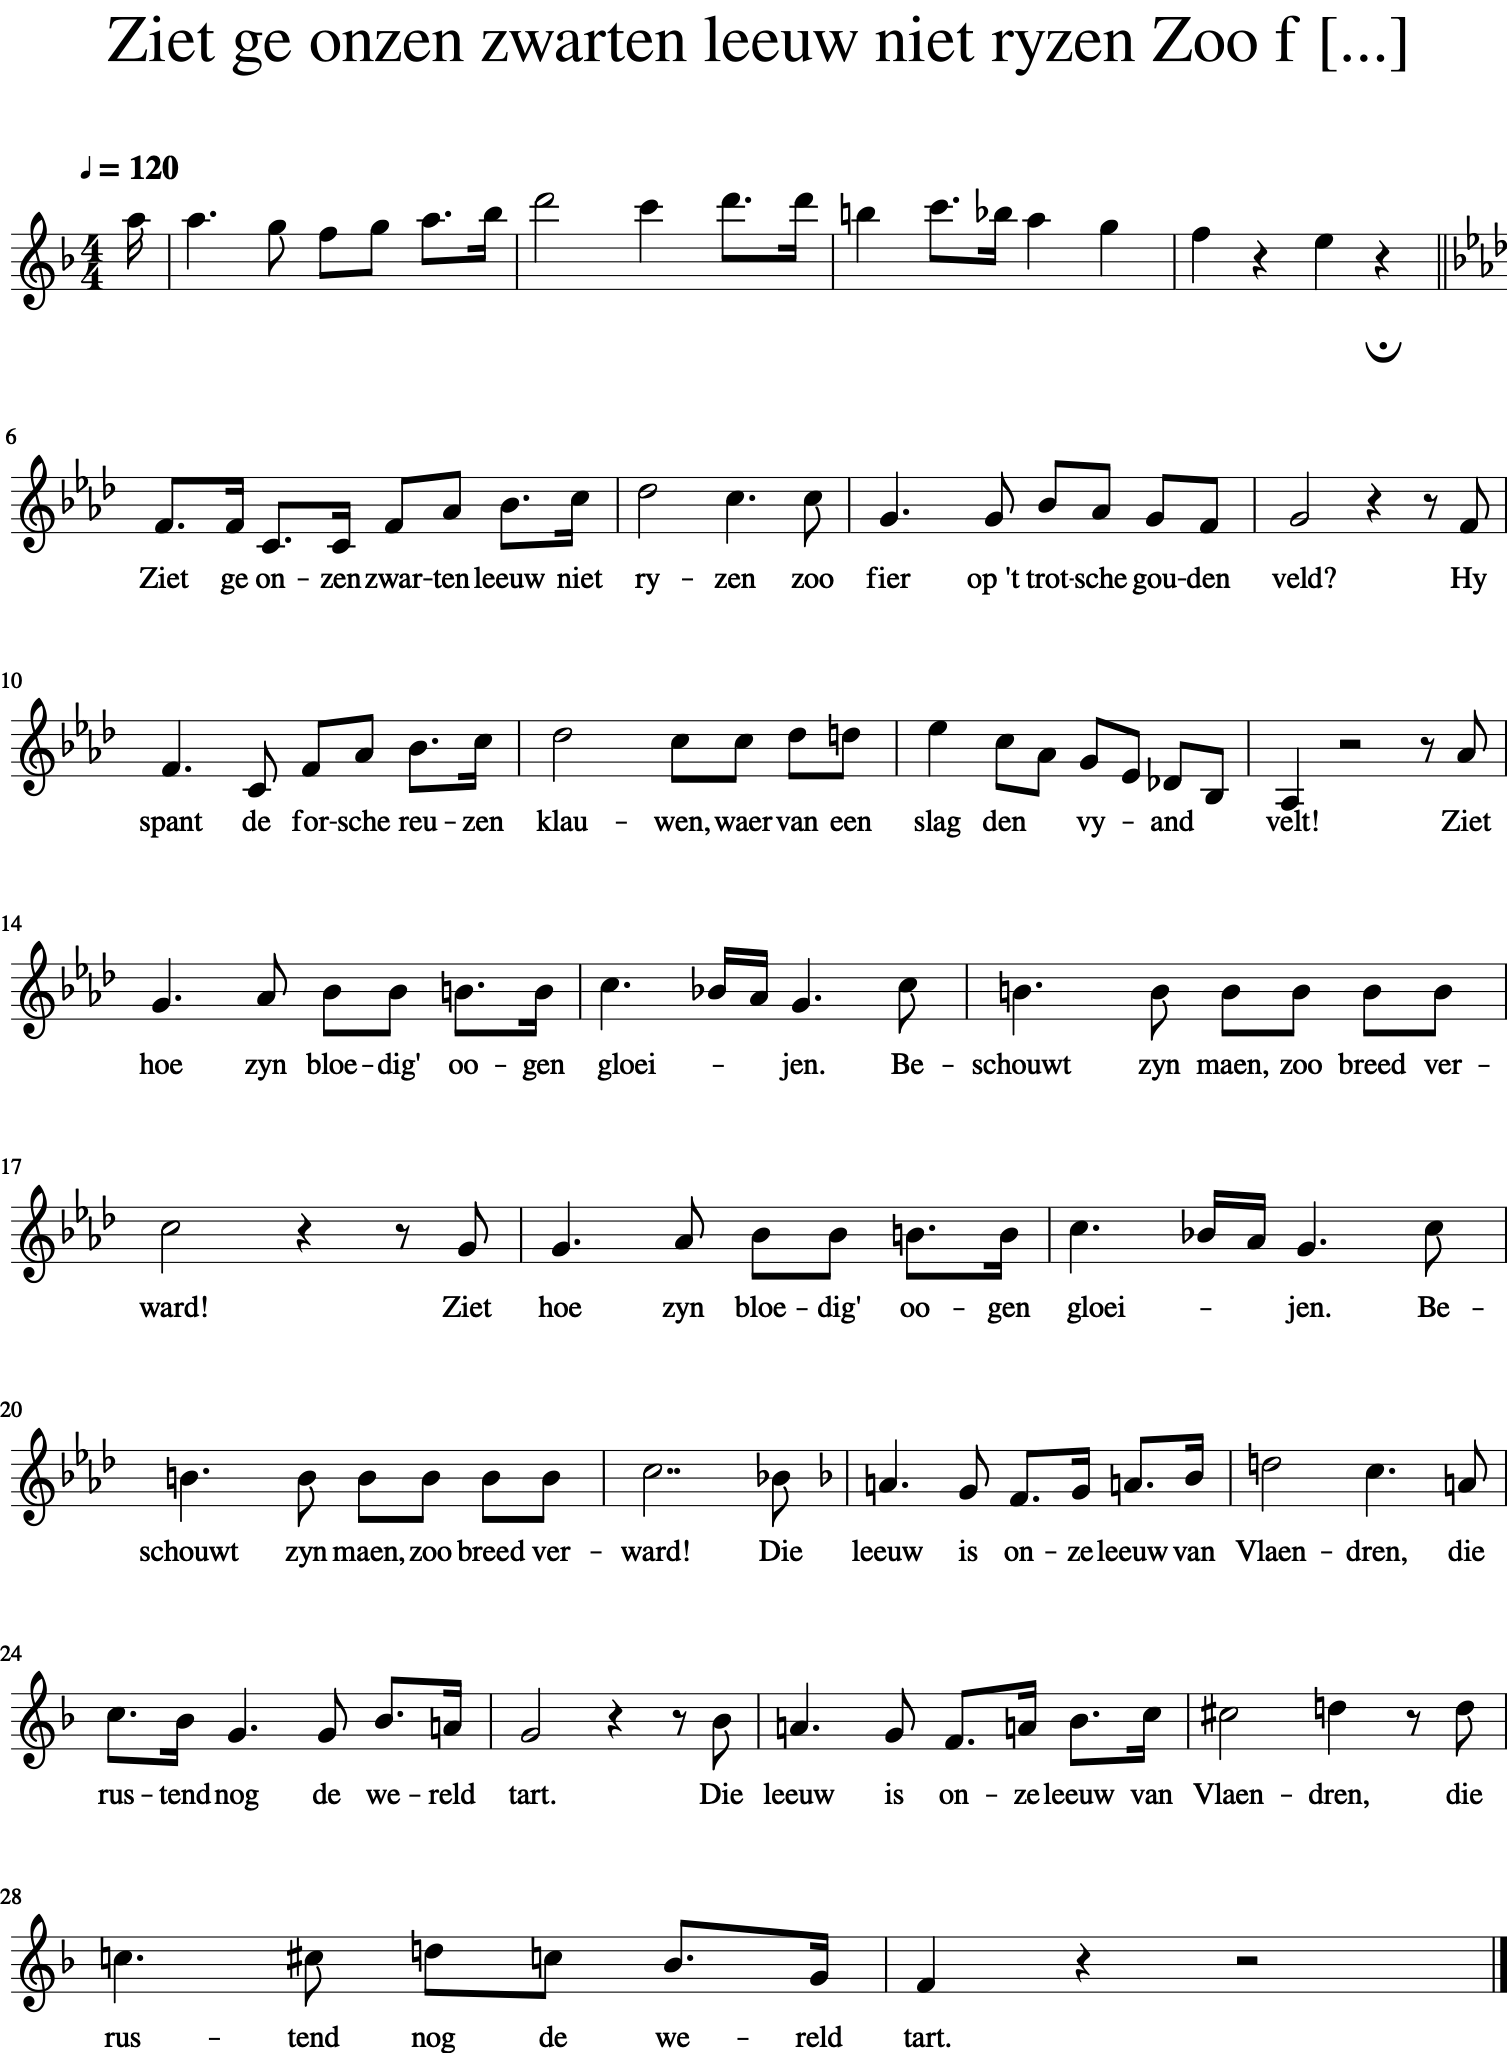

In [17]:
s.show()

In [18]:
removeNonContentsWords(s, annotateOnly=True)
lyricsToAllOfMelisma(s, moveToLast=True, annotateOnly=True)
for n in s.flat.notes:
    if n.tie:
        if n.tie.type == 'stop' or n.tie.type == 'continue':
            continue 
    print n, n.lyrics, n.noncontentword, n.melismastatus

No lyrics at first note.
<music21.note.Note A> [] False start
<music21.note.Note A> [] False in
<music21.note.Note G> [] False in
<music21.note.Note F> [] False in
<music21.note.Note G> [] False in
<music21.note.Note A> [] False in
<music21.note.Note B-> [] False in
<music21.note.Note D> [] False in
<music21.note.Note C> [] False in
<music21.note.Note D> [] False in
<music21.note.Note D> [] False in
<music21.note.Note B> [] False in
<music21.note.Note C> [] False in
<music21.note.Note B-> [] False in
<music21.note.Note A> [] False in
<music21.note.Note G> [] False in
<music21.note.Note F> [] False in
<music21.note.Note E> [] False end
<music21.note.Note F> [<music21.note.Lyric number=1 syllabic=single text="Ziet">] False end
<music21.note.Note F> [<music21.note.Lyric number=1 syllabic=single text="ge">] True end
<music21.note.Note C> [<music21.note.Lyric number=1 syllabic=begin text="on">] False end
<music21.note.Note C> [<music21.note.Lyric number=1 syllabic=end text="zen">] False end

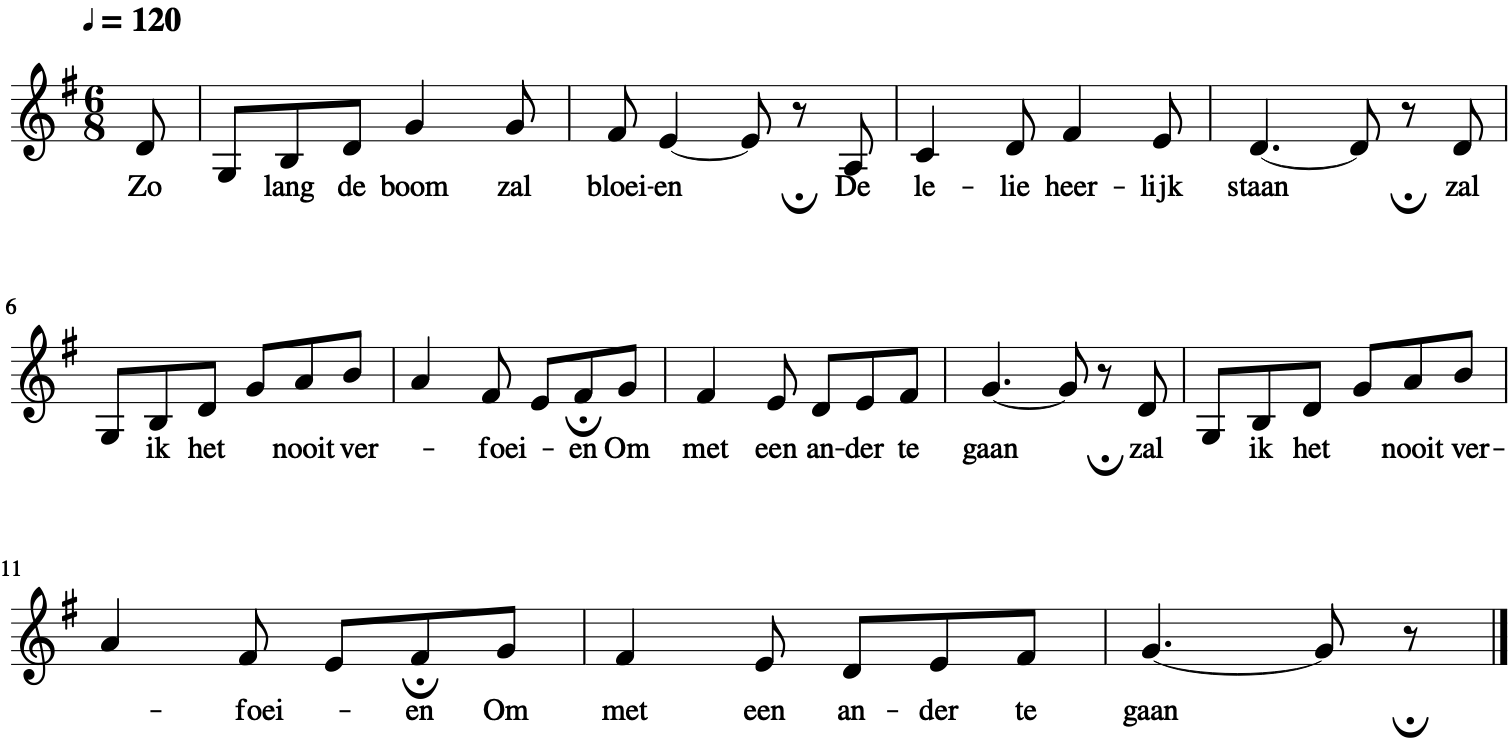

In [18]:
s.show()

In [10]:
s = converter.parse('/Users/pvk/data/MTC/MTC-ANN-2.0.1/krn/NLB070748_01.krn')

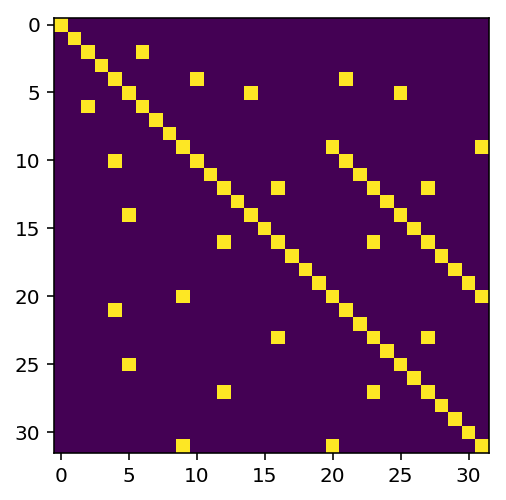

In [11]:
nlbid = 'NLB070748_01'
addPhonemes(s)
lyricsToEndOfMelisma(s)
words = collectPhonemeWords(s)
rh,rh_dist = detectRhymeWords(words,plot=True)
addRhymeToSong(s,rh,words)
s.insert(metadata.Metadata())
s.metadata.title = nlbid
addOffsetsAsLyrics(s)

In [12]:
print(list(zip(rh,rh_dist)))

[(False, 0), (False, 0), (True, 4), (False, 0), (True, 6), (True, 9), (True, 4), (False, 0), (False, 0), (True, 11), (True, 6), (False, 0), (True, 4), (False, 0), (True, 9), (False, 0), (True, 4), (False, 0), (False, 0), (False, 0), (True, 11), (True, 17), (False, 0), (True, 4), (False, 0), (True, 20), (False, 0), (True, 4), (False, 0), (False, 0), (False, 0), (True, 11)]


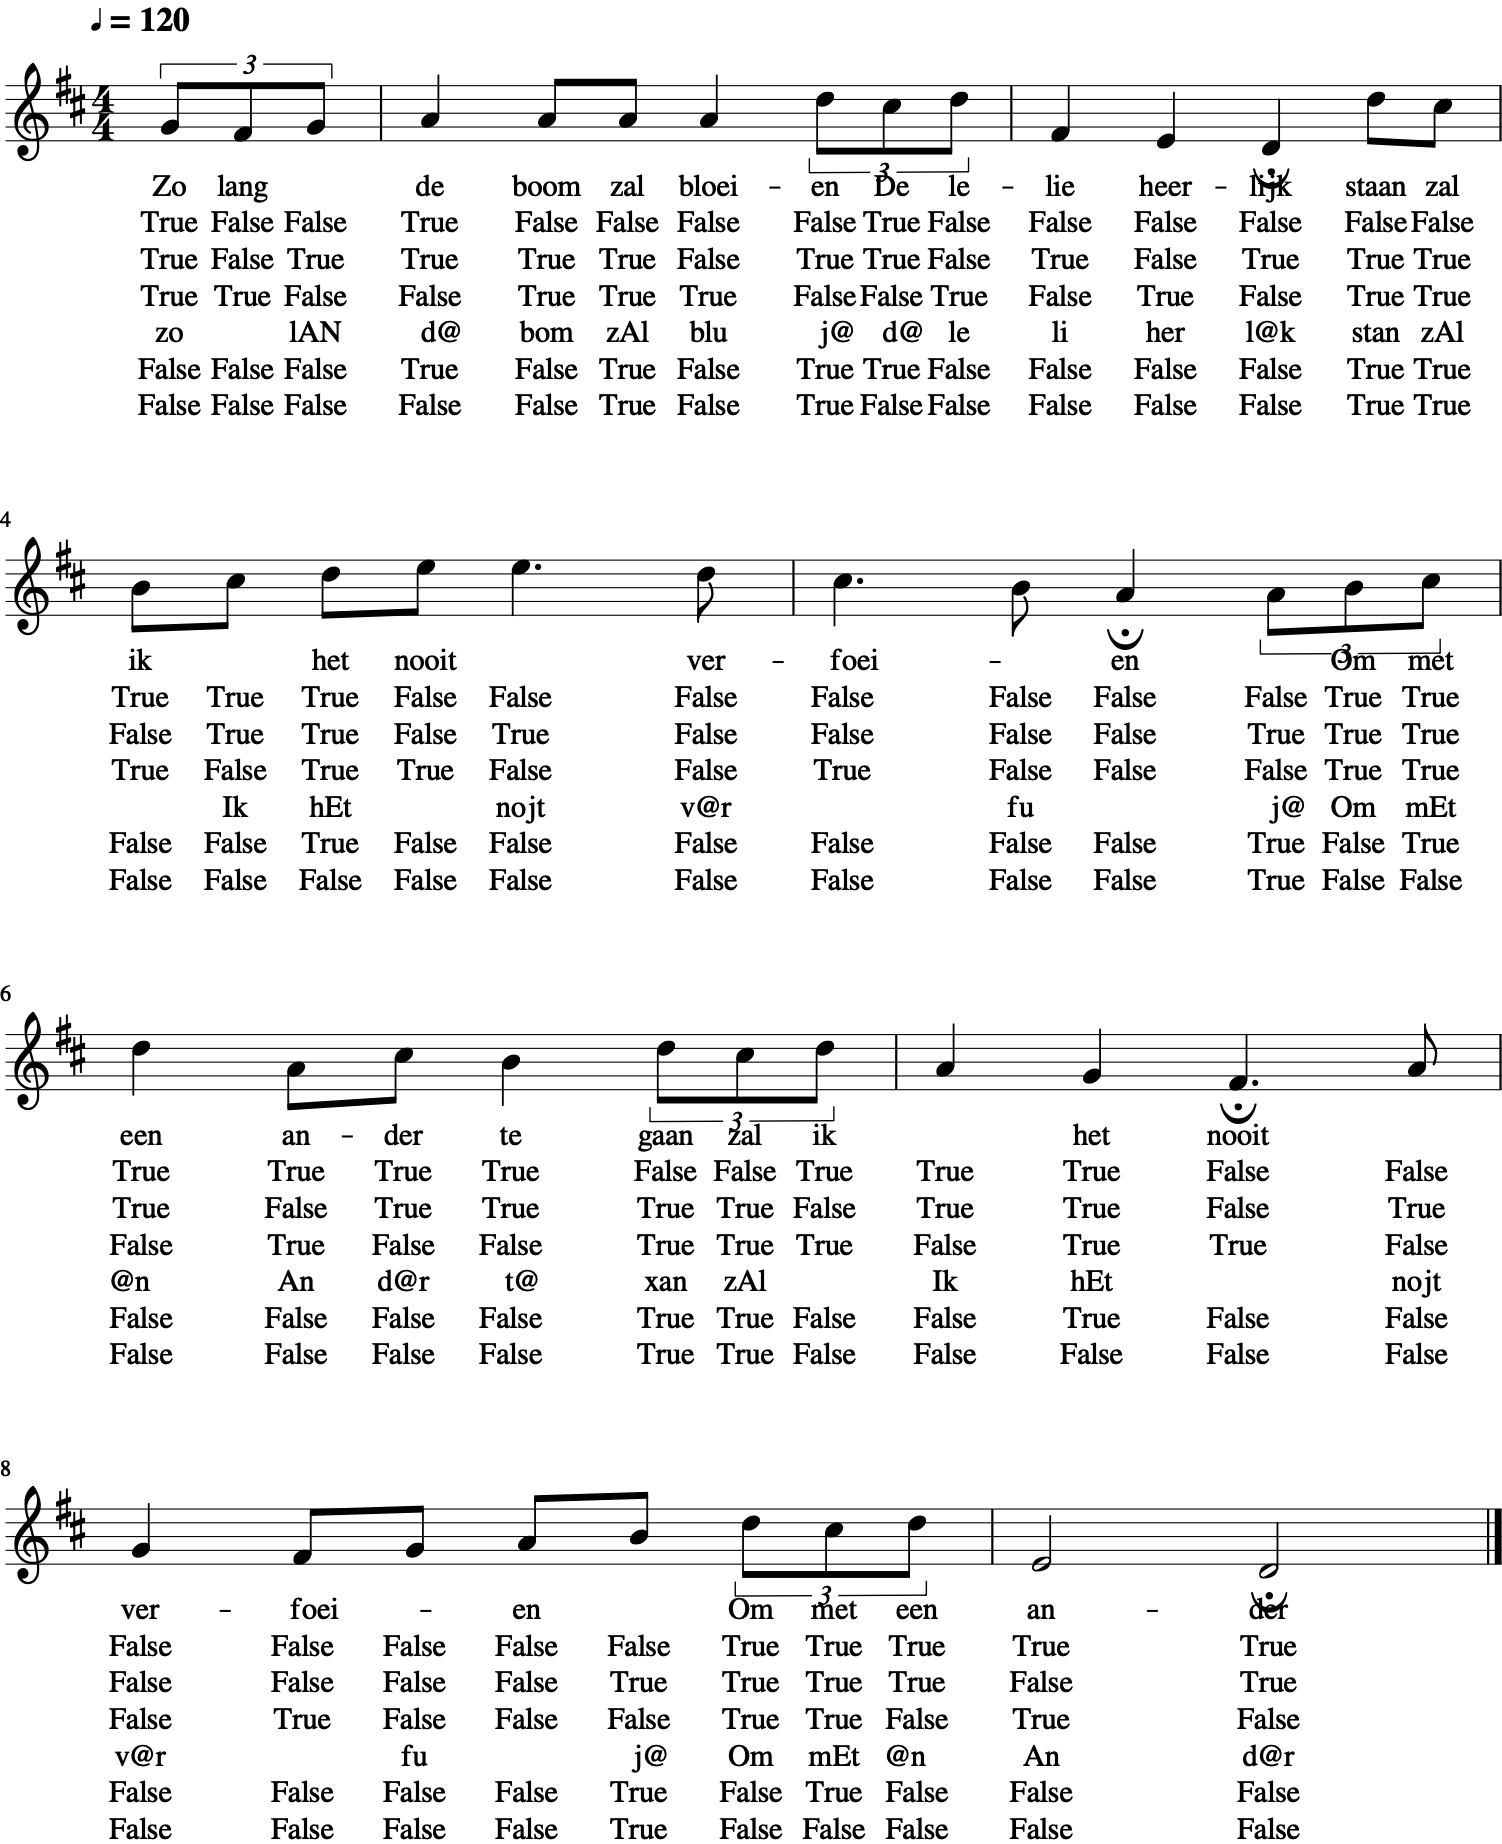

In [22]:
s.show()

In [26]:
print s.metadata.title

None
